In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Toy divergence-free 2D vector field generator
# ------------------------------------------------
# We generate a random streamfunction ψ(x,y) using a few low-frequency Fourier modes,
# then define velocity as u = ∂ψ/∂y, v = -∂ψ/∂x, which guarantees ∇·u = 0.
# We'll visualize the field and verify (approximate) zero divergence numerically.

def generate_div_free_field(n=128, modes=6, seed=42, amplitude_decay=2.0):
    rng = np.random.default_rng(seed)
    # Grid on [0, 2π) × [0, 2π) for periodicity
    L = 2*np.pi
    x = np.linspace(0, L, n, endpoint=False)
    y = np.linspace(0, L, n, endpoint=False)
    X, Y = np.meshgrid(x, y, indexing='xy')

    # Random low-frequency Fourier streamfunction
    psi = np.zeros((n, n), dtype=np.float64)
    # Sample a few modes with decaying amplitude
    ks = rng.integers(1, 6, size=(modes,))  # kx
    ls = rng.integers(1, 6, size=(modes,))  # ky
    for k, l in zip(ks, ls):
        a = rng.normal() / (k**amplitude_decay + l**amplitude_decay)
        b = rng.normal() / (k**amplitude_decay + l**amplitude_decay)
        # cos and sin components
        psi += a * np.cos(k*X + l*Y) + b * np.sin(k*X + l*Y)

    # Compute velocity field from streamfunction: u = dψ/dy, v = -dψ/dx
    # Use spectral differentiation (FFT) to preserve periodicity and accuracy
    kx = np.fft.fftfreq(n, d=L/n) * 2*np.pi  # wave numbers
    ky = np.fft.fftfreq(n, d=L/n) * 2*np.pi
    KX, KY = np.meshgrid(kx, ky, indexing='xy')

    psi_hat = np.fft.fft2(psi)
    # u = ∂ψ/∂y -> in Fourier: i*ky*ψ_hat
    u_hat = 1j * KY * psi_hat
    # v = -∂ψ/∂x -> in Fourier: -i*kx*ψ_hat
    v_hat = -1j * KX * psi_hat

    u = np.fft.ifft2(u_hat).real
    v = np.fft.ifft2(v_hat).real

    # Verify divergence numerically using spectral differentiation
    ux_hat = 1j * KX * np.fft.fft2(u)
    vy_hat = 1j * KY * np.fft.fft2(v)
    div = np.fft.ifft2(ux_hat + vy_hat).real

    # Normalise velocity to unit variance (optional, helpful for ML training)
    vel = np.stack([u, v], axis=-1)
    vel_mean = vel.mean(axis=(0,1), keepdims=True)
    vel_std = vel.std(axis=(0,1), keepdims=True) + 1e-8
    vel_norm = (vel - vel_mean) / vel_std
    u_norm = vel_norm[...,0]
    v_norm = vel_norm[...,1]

    # # Save dataset
    # out_path = "/mnt/data/div_free_field_npz.npz"
    # np.savez_compressed(out_path, x=x, y=y, psi=psi, u=u_norm, v=v_norm, 
    #                     meta=dict(n=n, modes=modes, seed=int(seed), L=L, 
    #                               amplitude_decay=amplitude_decay,
    #                               mean=vel_mean.squeeze().tolist(),
    #                               std=vel_std.squeeze().tolist()))

    # # Return data and diagnostics
    # stats = {
    #     "div_max_abs": float(np.abs(div).max()),
    #     "div_L2": float(np.sqrt(np.mean(div**2))),
    #     "u_std": float(u_norm.std()),
    #     "v_std": float(v_norm.std()),
    #     "u_mean": float(u_norm.mean()),
    #     "v_mean": float(v_norm.mean()),
    # }
    return X, Y, u_norm, v_norm, psi, div


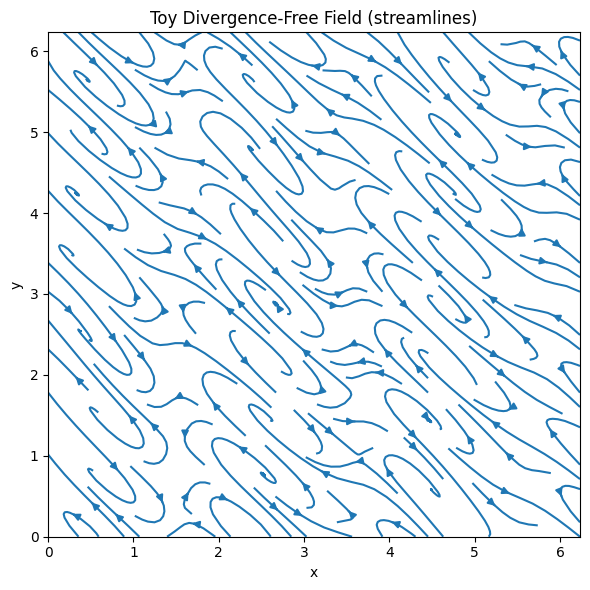

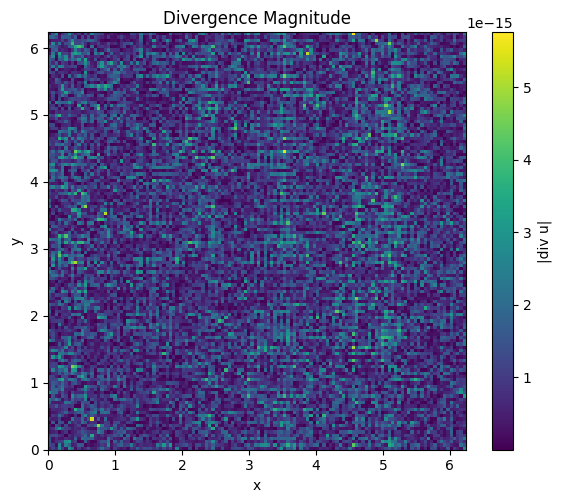

In [19]:
# Generate a field
X, Y, u, v, psi, div = generate_div_free_field(n=128, modes=6, seed=9, amplitude_decay=3)

# Plot 1: Streamlines of the velocity field
plt.figure(figsize=(6,6))
speed = np.sqrt(u**2 + v**2)
plt.streamplot(X, Y, u, v, density=1.2)
plt.title("Toy Divergence-Free Field (streamlines)")
plt.xlabel("x")
plt.ylabel("y")
plt.tight_layout()
plt.show()

# Plot 2: Divergence magnitude heatmap (should be ~0, up to numerical error)
plt.figure(figsize=(6,5))
plt.imshow(np.abs(div), origin='lower', extent=[X.min(), X.max(), Y.min(), Y.max()])
plt.colorbar(label="|div u|")
plt.title("Divergence Magnitude")
plt.xlabel("x")
plt.ylabel("y")
plt.tight_layout()
plt.show()